# Inverse design optimization of a bilayer grating coupler

This example demonstrates the co-optimization of two separate design regions using tidy3d inverse design. Instead of the `adjoint` plugin, we use the native automatic differentiation support built into `tidy3d` versions 2.7 and later. In this framework, regular `tidy3d` components and `web.run()` functions are differentiable without any change of syntax.

We optimize a grating coupler for coupling efficiency with respect to 
1. the pattern partially etched into a Si coupling layer.
2. the pattern etched into a SiN layer suspended above the coupling region.

Our example will roughly be following this [paper](https://iopscience.iop.org/article/10.1088/2515-7647/ac943c/meta).

<img src="img/adjoint_16.png" width=400 alt="Schematic of the grating coupler">


In [1]:
import autograd
import autograd.numpy as np
import matplotlib.pylab as plt
import tidy3d as td
import tidy3d.web as web

# define some length scales in tidy3d default of microns
um = 1.0
nm = 1e-3

## Set up simulation

First, we define everything "static" (not optimizing) in the simulation, including parameters and tidy3d components.

### Spectral Parameters

In [2]:
wavelength = 1310 * nm
freq = td.C_0 / wavelength
fwidth = freq/10
run_time = 50 / fwidth

### Geometric Parameters

In [3]:
# device parameters
thick_substrate = 2.0 * um
thick_Si = 220 * nm
thick_SiN = 600 * nm
thick_etch = 160 * nm
space_SiSiN = 100 * nm
width_waveguide = 500 * nm

# size of design region
size_design_x = 4 * um
size_design_y = 4 * um

# spacings between things (technically infinite, but finite for sim)
length_waveguide = 1 * wavelength
thick_Si_substrate = 550 * nm
space_cladding_top = 1 * wavelength
space_design_edge = 1 * wavelength

# compute sim size
size_sim_x = length_waveguide + size_design_x + space_design_edge
size_sim_y = space_design_edge + size_design_y + space_design_edge
size_sim_z = thick_Si_substrate + thick_substrate + thick_Si + space_SiSiN + thick_SiN + space_cladding_top
size_sim = (size_sim_x, size_sim_y, size_sim_z)

# references to various locations
sim_top_z = size_sim_z / 2.0
sim_bot_z = -size_sim_z / 2.0
center_SiN_z = sim_top_z - space_cladding_top - thick_SiN / 2.0
center_Si_z = sim_top_z - space_cladding_top - thick_SiN - space_SiSiN - thick_Si / 2.0
center_Si_etch_z = sim_top_z - space_cladding_top - thick_SiN - space_SiSiN - thick_etch / 2.0
center_source_z = sim_top_z - space_cladding_top / 2.0
center_Si_substrate_z = sim_bot_z + thick_Si_substrate / 2

center_waveguide_x = -size_sim_x/2 + length_waveguide / 2.0
center_design_x = size_sim_x / 2.0 - space_design_edge - size_design_x / 2.0

### Material Parameters

In [4]:
# dispersiveless materials for now. note: can also do `td.Medium.from_nk(n=n, k=k, freq=freq)`

n_SiO2 = 1.44
n_SiN = 2.0
n_Si = 3.5

eps_Si = n_Si**2
eps_SiN = n_SiN**2
eps_SiO2 = n_SiO2**2

medium_Si = td.Medium(permittivity=eps_Si)
medium_SiN = td.Medium(permittivity=eps_SiN)
medium_SiO2 = td.Medium(permittivity=eps_SiO2)

### Source Parameters

In [5]:
spot_size = np.sqrt(size_design_x**2 + size_design_y**2)
tilt_angle_deg = 0.0

### Static Components

In [6]:
waveguide = td.Structure(
    geometry=td.Box(
        center=(-size_sim_x + length_waveguide + size_design_x/2.0, 0, center_Si_z),
        size=(size_sim_x, width_waveguide, thick_Si)
    ),
    medium=medium_Si,
)

design_region = td.Structure(
    geometry=td.Box(
        center=(center_design_x, 0, center_Si_z),
        size=(size_design_x, size_design_y, thick_Si),
    ),
    medium=medium_Si,
)

slab_SiN = td.Structure(
    geometry=td.Box(
        center=(center_design_x, 0, center_SiN_z),
        size=(size_design_x, size_design_y, thick_SiN),
    ),
    medium=medium_SiN,
)

substrate_Si = td.Structure(
    geometry=td.Box(
        center=(0, 0, -size_sim_z + thick_Si_substrate),
        size=(td.inf, td.inf, size_sim_z),
    ),
    medium=medium_Si
)

gaussian_beam = td.GaussianBeam(
    center=(center_design_x, 0, center_source_z),
    size=(size_design_x, size_design_y, 0),
    source_time=td.GaussianPulse(freq0=freq, fwidth=fwidth),
    pol_angle=np.pi / 2,
    angle_theta=tilt_angle_deg * np.pi / 180.0,
    direction="-",
    num_freqs=7,
    waist_radius=spot_size / 2,
)

mode_monitor = td.ModeMonitor(
    size=(0, width_waveguide * 6, thick_Si * 6),
    center=(center_waveguide_x, 0, center_Si_z),
    name='mode',
    freqs=[freq],
    mode_spec=td.ModeSpec()
)

field_monitor_xy = td.FieldMonitor(
    center=(0, 0, center_Si_z),
    size=(td.inf, td.inf, 0),
    freqs=[freq],
    name='field_xy',
)

field_monitor_xz = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, 0, td.inf),
    freqs=[freq],
    name='field_xz',
)

sim_no_etch = td.Simulation(
    size=size_sim,
    run_time=run_time,
    medium=medium_SiO2,
    structures=[waveguide, design_region, slab_SiN, substrate_Si],
    grid_spec=td.GridSpec.auto(wavelength=wavelength),
    sources=[gaussian_beam],
    monitors=[mode_monitor, field_monitor_xy, field_monitor_xz],
)

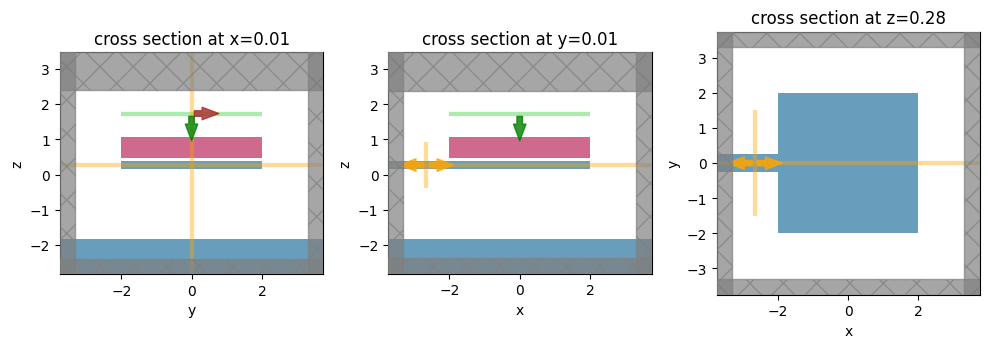

In [7]:
# shift the plot positions a little so the field monitors don't overlap plots
shift_plot = 0.01

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4), tight_layout=True)
sim_no_etch.plot(x=0.0 + shift_plot, ax=ax1)
sim_no_etch.plot(y=0.0 + shift_plot, ax=ax2)
sim_no_etch.plot(z=center_Si_z + shift_plot, ax=ax3)
plt.show()

### Inspect waveguide modes

We will run the mode solver to determine the proper `mode_index` correponding to the fundamental TE mode.

In [8]:
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver

num_modes = 3
mode_spec = td.ModeSpec(num_modes=num_modes)

mode_solver = ModeSolver(
    simulation=sim_no_etch,
    plane=mode_monitor.geometry,
    mode_spec=mode_spec,
    freqs=[freq],
)
modes = run_mode_solver(mode_solver, reduce_simulation=True)

22:34:32 EDT Mode solver created with                                           
             task_id='fdve-857be27f-22f0-4819-ba50-9babfae32175',               
             solver_id='mo-65066fe4-da88-4fb8-89c8-c76c90cfcff9'.

Output()

Output()

22:34:34 EDT Mode solver status: queued

22:34:44 EDT Mode solver status: running

22:34:51 EDT Mode solver status: success

Output()

Effective index of computed modes:  [[2.7003791 2.189336  1.8199656]]


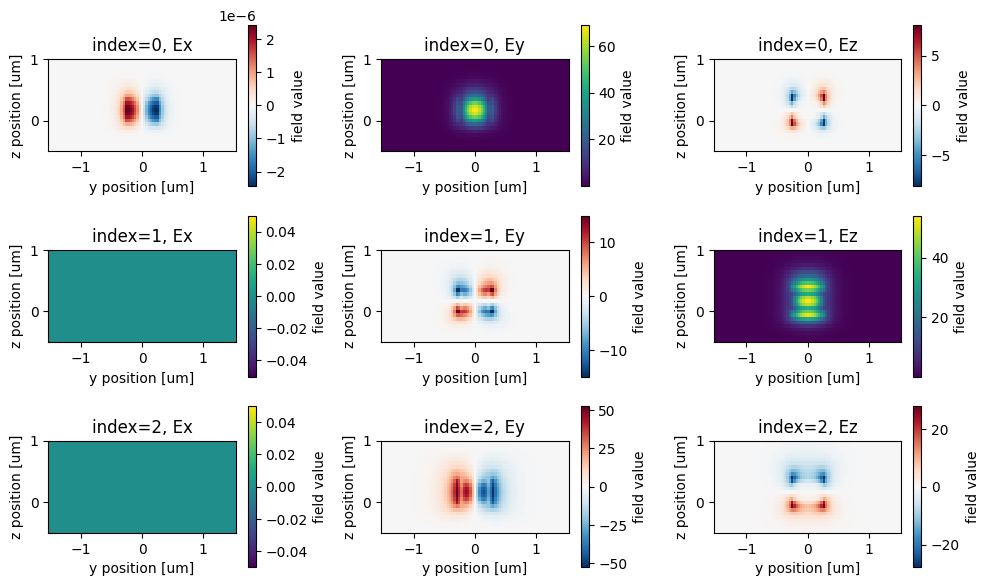

In [9]:
fig, axs = plt.subplots(num_modes, 3, figsize=(10, 6), tight_layout=True)
for mode_index in range(num_modes):

    vmax = 1.1 * max(
        abs(modes.field_components[key].sel(mode_index=mode_index)).max() for key in ("Ex", "Ey", "Ez")
    )
    
    for field_name, ax in zip(("Ex", "Ey", "Ez"), axs[mode_index]):
        field = modes.field_components[field_name].sel(mode_index=mode_index)
        field.real.squeeze().plot.imshow(x='y', y='z', label="Real", ax=ax)
        ax.set_title(f"index={mode_index}, {field_name}")
        ax.set_aspect('equal')
        
print("Effective index of computed modes: ", np.array(modes.n_eff))

# mode_index=0 corresponds to our mode of interest, so we'll keep our mode spec with default num_modes=1.

## Include Etch Regions

Next, we'll define the functions describing our two etched design regions.

Starting from raw optimization parameters, we will use filtering and projection techniques to obtain an "etch density" pattern. We then rescale this to the etched and un-etched permittivity values. Finally, we package the etch pattern as a `Structure` containing a `CustomMedium`.

In [10]:
from tidy3d.plugins.autograd.functions import rescale
from tidy3d.plugins.autograd.invdes import make_filter_and_project, get_kernel_size_px

# resolution of the design region pixels
pixel_size_Si = 15 * nm
pixel_size_SiN = 15 * nm

# radius of the circular filter (um) (higher = larger features)
radius_Si = 100 * nm
radius_SiN = 100 * nm

# projection strengths (higher = more binarized)
beta_Si = 5
beta_SiN = 5
beta_penalty = 5

# filter sizes (in pixels) for each of the design regions
filter_size_Si = get_kernel_size_px(radius_Si, pixel_size_Si)
filter_size_SiN = get_kernel_size_px(radius_SiN, pixel_size_SiN)

nx_Si = int(size_design_x // pixel_size_Si)
ny_Si = int(size_design_y // pixel_size_Si)
nx_SiN = int(size_design_x // pixel_size_SiN)
ny_SiN = int(size_design_y // pixel_size_SiN)

etch_Si_geometry = geometry=td.Box(
    size=(size_design_x, size_design_y, thick_etch),
    center=(center_design_x, 0, center_Si_etch_z)
)

def get_density(params: np.ndarray, radius: float, beta: float, pixel_size: float) -> np.ndarray:
    """Generic function to get the etch density as a function of design parameters, using filter and projection."""
    filter_size = get_kernel_size_px(radius, pixel_size)
    filter_project = make_filter_and_project(filter_size, beta=beta)
    return filter_project(params)

def get_density_Si(params: np.ndarray) -> td.Structure:
    """Get the density of the Si etch as a function of its design parameters."""
    return get_density(params=params, radius=radius_Si, beta=beta_Si, pixel_size=pixel_size_Si)

def get_density_SiN(params: np.ndarray) -> td.Structure:
    """Get the density of the SiN etch as a function of its design parameters."""
    return get_density(params=params, radius=radius_SiN, beta=beta_SiN, pixel_size=pixel_size_SiN)

def get_permittivity(density: np.ndarray, eps_max: float) -> np.ndarray:
    """Get the permittivity array between SiO2 and the max, given an array of material densities between 0 and 1."""
    return rescale(density, eps_SiO2, eps_max)

def make_etch_structure(density: np.ndarray, eps_max: float, geometry: td.Box) -> td.Structure:
    """Make a `td.Structure` containing a `td.CustomMedium` corresponding to this density array, given a geometry."""

    permittivity_data = get_permittivity(density, eps_max=eps_max)

    rmin, rmax = geometry.bounds
    coords = {}
    for (key, pt_min, pt_max, num_pts) in zip('xyz', rmin, rmax, density.shape):
        coord_edges = np.linspace(pt_min, pt_max, num_pts + 1)
        coord_centers = (coord_edges[1:] + coord_edges[:-1]) / 2.0
        coords[key] = coord_centers

    custom_medium = td.CustomMedium(
        permittivity=td.ScalarFieldDataArray(
            permittivity_data,
            coords=coords,
        )
    )

    return td.Structure(geometry=geometry, medium=custom_medium)

def get_etch_Si(params: np.ndarray) -> td.Structure:
    """Get the etch region for Si, using the Si parameters."""
    density = get_density_Si(params)
    return make_etch_structure(density=density, eps_max=eps_Si, geometry=etch_Si_geometry)

def get_etch_SiN(params: np.ndarray) -> td.Structure:
    """Get the etch region for SiN, using the SiN parameters."""
    density = get_density_SiN(params)
    return make_etch_structure(density=density, eps_max=eps_SiN, geometry=slab_SiN.geometry)



## Optimization Parameterization

Next we will write a few other functions to help define our `Simulation` itself from the design parameters.

In [11]:
def make_sim_with_etch(params_Si: np.ndarray, params_SiN: np.ndarray) -> td.Simulation:
    """Make a simulation as a function of the design parameters for Si and SiN etch regions."""
    etch_Si = get_etch_Si(params_Si)
    etch_SiN = get_etch_SiN(params_SiN)

    # add uniform mesh override structures to simulation
    design_region_mesh_Si = td.MeshOverrideStructure(
        geometry=design_region.geometry,
        dl=[pixel_size_Si] * 3,
        enforce=True,
    )

    design_region_mesh_SiN = td.MeshOverrideStructure(
        geometry=slab_SiN.geometry,
        dl=[pixel_size_SiN] * 3,
        enforce=True,
    )

    grid_spec = sim_no_etch.grid_spec.updated_copy(
        override_structures=list(sim_no_etch.grid_spec.override_structures) + [design_region_mesh_Si, design_region_mesh_SiN]
    )

    return sim_no_etch.updated_copy(
        structures=list(sim_no_etch.structures) + [etch_Si, etch_SiN],
        grid_spec=grid_spec,
    )

Let's create some initial parameters to test our parameterization with.

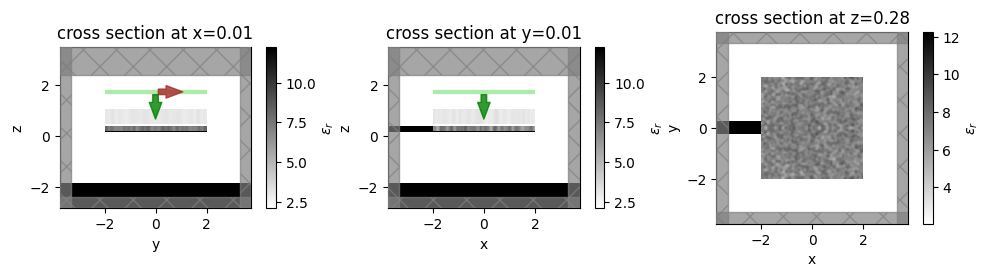

In [12]:
def make_symmetric_y(arr: np.ndarray) -> np.ndarray:
    """make an array symmetric in y."""
    return (arr + np.fliplr(arr)) / 2.0

params0_Si = make_symmetric_y(np.random.random((nx_Si, ny_Si, 1)))
params0_SiN = make_symmetric_y(np.random.random((nx_SiN, ny_SiN, 1)))

sim_etch_random = make_sim_with_etch(params0_Si, params0_SiN)

f, axes = f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4), tight_layout=True)
sim_etch_random.plot_eps(x=0.0 + shift_plot, monitor_alpha=0.0, ax=ax1)
sim_etch_random.plot_eps(y=0.0 + shift_plot, monitor_alpha=0.0, ax=ax2)
sim_etch_random.plot_eps(z=center_Si_z + shift_plot, monitor_alpha=0.0, ax=ax3)

for ax in axes:
    ax.set_aspect('equal')
    
plt.show()

In [13]:
sim_data = web.run(sim_etch_random, task_name='check fields')

22:34:53 EDT Created task 'check fields' with task_id                           
             'fdve-63596e26-0e53-4c45-8d8e-8e88f735e8ca' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=337718;https://tidy3d.simulation.cloud/workbench?taskId=fdve-63596e26-0e53-4c45-8d8e-8e88f735e8ca\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=209731;https://tidy3d.simulation.cloud/workbench?taskId=fdve-63596e26-0e53-4c45-8d8e-8e88f735e8ca\taskId]8;;\]8;id=337718;https://tidy3d.simulation.cloud/workbench?taskId=fdve-63596e26-0e53-4c45-8d8e-8e88f735e8ca\=]8;;\]8;id=253064;https://tidy3d.simulation.cloud/workbench?taskId=fdve-63596e26-0e53-4c45-8d8e-8e88f735e8ca\fdve]8;;\]8;id=337718;https://tidy3d.simulation.cloud/workbench?taskId=fdve-63596e26-0e53-4c45-8d8e-8e88f735e8ca\-63596e26-0e5]8;;\
             ]8;id=337718;https://tidy3d.simulation.cloud/workbench?taskId=fdve-63596e26-0e53-4c45-8d8e-8e88f735e8ca\3-4c45-8d8e-8e88f735e8ca']8;;\.

Output()

22:34:57 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

22:35:10 EDT status = preprocess

22:35:13 EDT Maximum FlexCredit cost: 0.477. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

22:36:15 EDT early shutoff detected at 20%, exiting.

             status = postprocess

Output()

22:36:21 EDT status = success

             View simulation result at                                          
             ]8;id=888257;https://tidy3d.simulation.cloud/workbench?taskId=fdve-63596e26-0e53-4c45-8d8e-8e88f735e8ca\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=64011;https://tidy3d.simulation.cloud/workbench?taskId=fdve-63596e26-0e53-4c45-8d8e-8e88f735e8ca\taskId]8;;\]8;id=888257;https://tidy3d.simulation.cloud/workbench?taskId=fdve-63596e26-0e53-4c45-8d8e-8e88f735e8ca\=]8;;\]8;id=441884;https://tidy3d.simulation.cloud/workbench?taskId=fdve-63596e26-0e53-4c45-8d8e-8e88f735e8ca\fdve]8;;\]8;id=888257;https://tidy3d.simulation.cloud/workbench?taskId=fdve-63596e26-0e53-4c45-8d8e-8e88f735e8ca\-63596e26-0e5]8;;\
             ]8;id=888257;https://tidy3d.simulation.cloud/workbench?taskId=fdve-63596e26-0e53-4c45-8d8e-8e88f735e8ca\3-4c45-8d8e-8e88f735e8ca']8;;\.

Output()

22:36:23 EDT loading simulation from simulation_data.hdf5

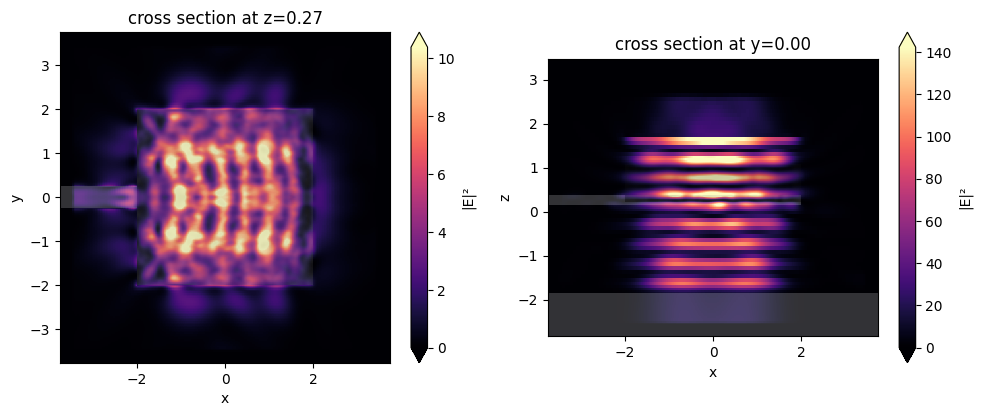

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

sim_data.plot_field('field_xy', field_name='E', val='abs^2', ax=ax1)
sim_data.plot_field('field_xz', field_name='E', val='abs^2', ax=ax2)

plt.show()

## Define Objective Function

The next step involves defining our objective function, which we seek to maximize with respect to the parameters.

We'll compute the coupling efficiency for the grating coupler, and also include a penalty for each of the design regions depending on how well they satisfy minimum feature size criteria.

In [15]:
from tidy3d.plugins.autograd.invdes import make_erosion_dilation_penalty

penalty_fn_Si = make_erosion_dilation_penalty(filter_size_Si, beta=beta_penalty)
penalty_fn_SiN = make_erosion_dilation_penalty(filter_size_SiN, beta=beta_penalty)

def penalty_Si(params: np.ndarray) -> float:
    """Define the erosion dilation invariance penalty for Si density parameters."""
    density = get_density_Si(params)
    return penalty_fn_Si(density)

def penalty_SiN(params: np.ndarray) -> float:
    """Define the erosion dilation invariance penalty for SiN density parameters."""
    density = get_density_SiN(params)
    return penalty_fn_SiN(density)

def coupling_efficiency(sim_data: td.SimulationData) -> float:
    """Coupling efficiency into the waveguide as a function of the simulation output data."""
    output_amps = sim_data["mode"].amps
    amp = output_amps.sel(direction="-", f=freq, mode_index=0).values
    return np.sum(np.abs(amp) ** 2)

In [16]:
def objective(params_Si: np.ndarray, params_SiN, verbose:bool=False, include_field_mnts: bool=False) -> float:
    """Combined objective function over the full set of parameters."""

    # coupling efficiency calculation, through a differentiable simulation
    sim = make_sim_with_etch(params_Si, params_SiN)
    if not include_field_mnts:
        sim = sim.updated_copy(monitors=[mode_monitor])
    data = web.run(sim, task_name='coupler', verbose=verbose)
    efficiency = coupling_efficiency(data)

    # fabrication penalty calculation for both design regions
    penalty_val_Si = penalty_Si(params_Si)
    penalty_val_SiN = penalty_SiN(params_SiN)

    # total objective (to maximize)
    coupling_objective = 2 * efficiency
    penalty_objective = 0.5 * (penalty_val_Si + penalty_val_SiN)
    return coupling_objective - penalty_objective
    

Let's test this out and inspect the gradients for each design region as a function of space.

In [ ]:
val_grad_fn = autograd.value_and_grad(objective, argnum=(0,1))

In [18]:
val, grads = val_grad_fn(params0_Si, params0_SiN, verbose=True)

14:04:46 EDT Created task 'coupler' with task_id                                
             'fdve-3e44e52e-133f-4bf0-a10c-1d6892dc63e5' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=766333;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e44e52e-133f-4bf0-a10c-1d6892dc63e5\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=807913;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e44e52e-133f-4bf0-a10c-1d6892dc63e5\taskId]8;;\]8;id=766333;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e44e52e-133f-4bf0-a10c-1d6892dc63e5\=]8;;\]8;id=884122;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e44e52e-133f-4bf0-a10c-1d6892dc63e5\fdve]8;;\]8;id=766333;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e44e52e-133f-4bf0-a10c-1d6892dc63e5\-3e44e52e-133]8;;\
             ]8;id=766333;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e44e52e-133f-4bf0-a10c-1d6892dc63e5\f-4bf0-a10c-1d6892dc63e5']8;;\.

Output()

14:04:51 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

14:05:00 EDT status = preprocess

14:05:04 EDT Maximum FlexCredit cost: 0.486. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

14:06:03 EDT early shutoff detected at 16%, exiting.

14:06:04 EDT status = postprocess

Output()

14:06:21 EDT status = success

             View simulation result at                                          
             ]8;id=524839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e44e52e-133f-4bf0-a10c-1d6892dc63e5\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=37022;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e44e52e-133f-4bf0-a10c-1d6892dc63e5\taskId]8;;\]8;id=524839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e44e52e-133f-4bf0-a10c-1d6892dc63e5\=]8;;\]8;id=908291;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e44e52e-133f-4bf0-a10c-1d6892dc63e5\fdve]8;;\]8;id=524839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e44e52e-133f-4bf0-a10c-1d6892dc63e5\-3e44e52e-133]8;;\
             ]8;id=524839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3e44e52e-133f-4bf0-a10c-1d6892dc63e5\f-4bf0-a10c-1d6892dc63e5']8;;\.

Output()

14:08:24 EDT loading simulation from simulation_data.hdf5

14:08:25 EDT Created task 'coupler_adjoint' with task_id                        
             'fdve-8030dcc8-fa6e-452e-877d-61e762d87d27' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=685941;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8030dcc8-fa6e-452e-877d-61e762d87d27\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=892048;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8030dcc8-fa6e-452e-877d-61e762d87d27\taskId]8;;\]8;id=685941;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8030dcc8-fa6e-452e-877d-61e762d87d27\=]8;;\]8;id=87457;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8030dcc8-fa6e-452e-877d-61e762d87d27\fdve]8;;\]8;id=685941;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8030dcc8-fa6e-452e-877d-61e762d87d27\-8030dcc8-fa6]8;;\
             ]8;id=685941;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8030dcc8-fa6e-452e-877d-61e762d87d27\e-452e-877d-61e762d87d27']8;;\.

Output()

14:08:29 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

14:08:58 EDT status = preprocess

14:09:02 EDT Maximum FlexCredit cost: 0.486. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

14:09:03 EDT running solver

Output()

14:10:07 EDT early shutoff detected at 44%, exiting.

14:10:08 EDT status = postprocess

Output()

14:10:12 EDT status = success

             View simulation result at                                          
             ]8;id=102871;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8030dcc8-fa6e-452e-877d-61e762d87d27\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=697492;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8030dcc8-fa6e-452e-877d-61e762d87d27\taskId]8;;\]8;id=102871;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8030dcc8-fa6e-452e-877d-61e762d87d27\=]8;;\]8;id=304656;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8030dcc8-fa6e-452e-877d-61e762d87d27\fdve]8;;\]8;id=102871;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8030dcc8-fa6e-452e-877d-61e762d87d27\-8030dcc8-fa6]8;;\
             ]8;id=102871;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8030dcc8-fa6e-452e-877d-61e762d87d27\e-452e-877d-61e762d87d27']8;;\.

Output()

14:12:25 EDT loading simulation from simulation_data.hdf5

objective function value = -0.8562743219274935


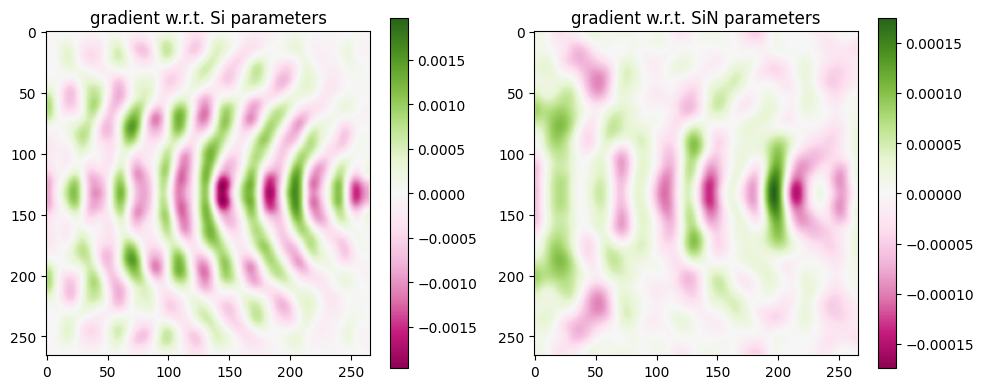

In [19]:
grad_Si, grad_SiN = grads

print(f'objective function value = {val}')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

vmag1 = np.max(abs(grad_Si))
im1 = ax1.imshow(np.flipud(np.squeeze(grad_Si)).T, cmap='PiYG', vmax=vmag1, vmin=-vmag1)
plt.colorbar(im1, ax=ax1)
ax1.set_title('gradient w.r.t. Si parameters')

vmag2 = np.max(abs(grad_SiN))
im2 = ax2.imshow(np.flipud(np.squeeze(grad_SiN)).T, cmap='PiYG', vmax=vmag2, vmin=-vmag2)
plt.colorbar(im2, ax=ax2)
ax2.set_title('gradient w.r.t. SiN parameters')

plt.show()

> For reference: The green regions represent where we would need to locally  **increase** parameters to increase the objective function and the purple regions represent where we would need to locally **decrease** parameters to increase our objective function.

## Optimization

Let's use our objective function gradient calculator to perform optimization. Like in the `adjoint` notebooks, we use `optax` to do `Adam` optimization in a for loop, feeding it our gradient computed at each iteration.

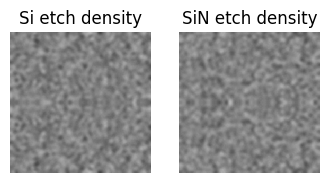

step = 1
	objective = -8.5627e-01
	grad_norm = 1.2947e-01


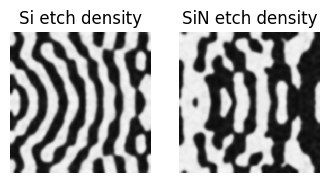

step = 2
	objective = 1.9587e-01
	grad_norm = 2.0562e+00


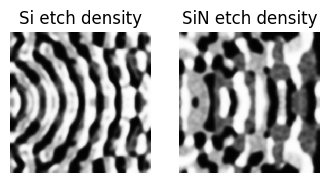

step = 3
	objective = -1.4443e-01
	grad_norm = 3.6321e+00


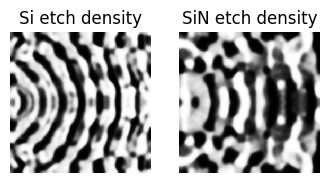

step = 4
	objective = 8.6646e-02
	grad_norm = 4.3589e+00


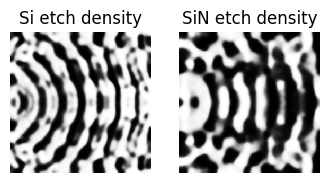

step = 5
	objective = 2.7739e-01
	grad_norm = 2.1232e+00


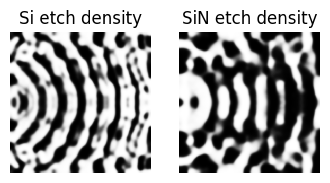

step = 6
	objective = 3.7629e-01
	grad_norm = 1.9154e+00


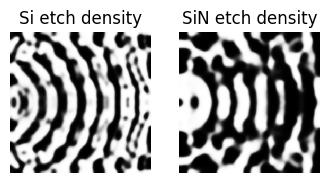

step = 7
	objective = 4.6175e-01
	grad_norm = 1.3695e+00


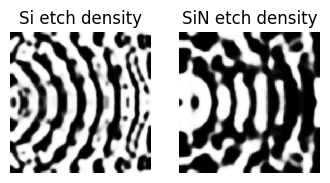

step = 8
	objective = 5.1405e-01
	grad_norm = 1.5579e+00


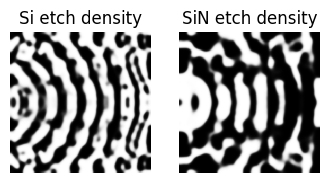

step = 9
	objective = 5.7785e-01
	grad_norm = 1.2423e+00


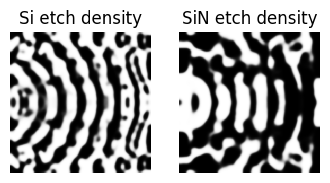

step = 10
	objective = 6.3043e-01
	grad_norm = 1.3185e+00


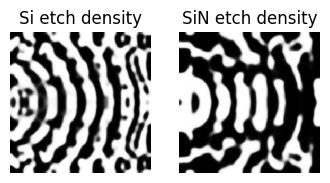

step = 11
	objective = 6.8205e-01
	grad_norm = 1.0396e+00


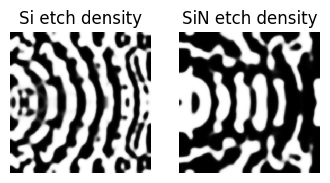

step = 12
	objective = 7.1418e-01
	grad_norm = 1.0170e+00


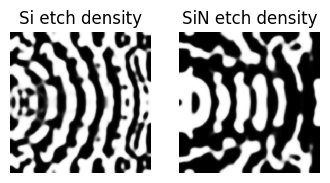

step = 13
	objective = 7.4116e-01
	grad_norm = 1.1957e+00


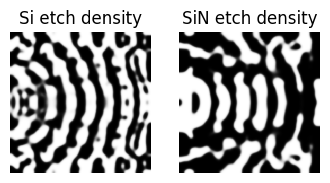

step = 14
	objective = 7.7688e-01
	grad_norm = 8.8202e-01


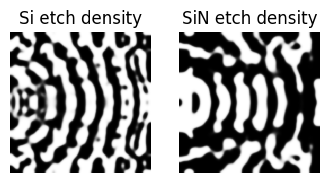

step = 15
	objective = 7.9170e-01
	grad_norm = 1.1586e+00


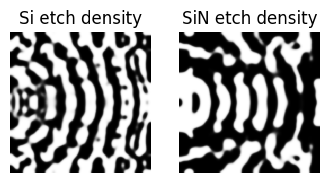

step = 16
	objective = 8.0487e-01
	grad_norm = 1.2697e+00


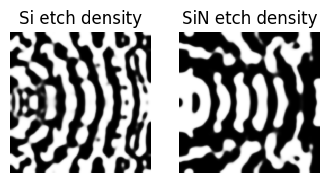

step = 17
	objective = 8.2799e-01
	grad_norm = 1.0197e+00


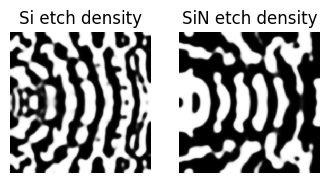

step = 18
	objective = 8.4802e-01
	grad_norm = 6.0635e-01


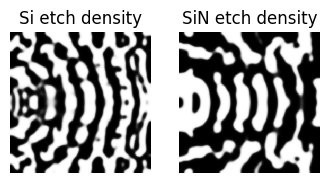

step = 19
	objective = 8.5870e-01
	grad_norm = 9.2243e-01


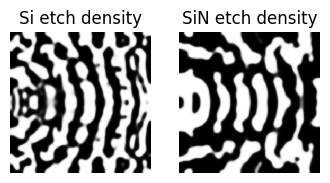

step = 20
	objective = 8.7017e-01
	grad_norm = 1.0204e+00


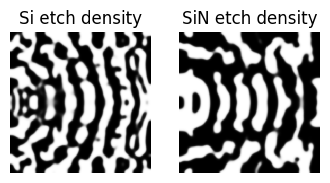

step = 21
	objective = 8.7891e-01
	grad_norm = 1.2551e+00


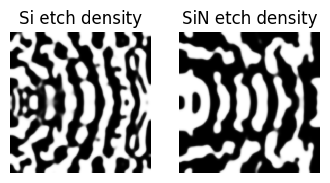

step = 22
	objective = 8.8841e-01
	grad_norm = 1.4055e+00


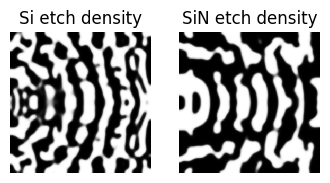

step = 23
	objective = 8.9863e-01
	grad_norm = 1.2631e+00


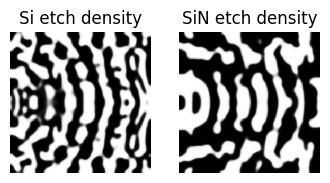

17:11:43 EDT WARNING: No connection: Retrying for 180 seconds.                  

17:19:30 EDT WARNING: No connection: Retrying for 180 seconds.                  

step = 24
	objective = 9.0591e-01
	grad_norm = 1.5261e+00


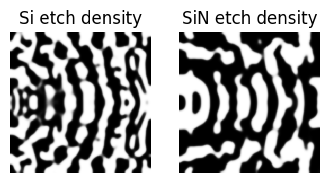

step = 25
	objective = 9.0870e-01
	grad_norm = 1.9661e+00


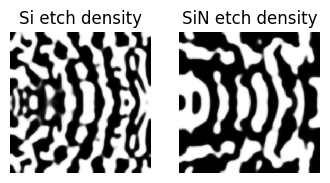

step = 26
	objective = 9.1386e-01
	grad_norm = 1.9490e+00


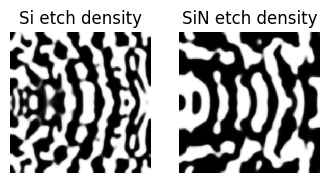

step = 27
	objective = 9.2626e-01
	grad_norm = 1.2052e+00


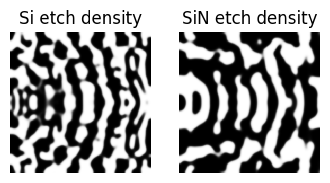

step = 28
	objective = 9.3537e-01
	grad_norm = 7.4286e-01


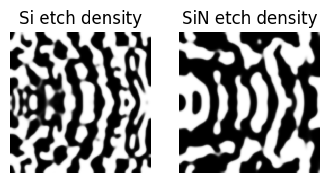

step = 29
	objective = 9.3830e-01
	grad_norm = 1.2399e+00


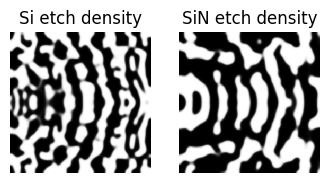

step = 30
	objective = 9.4493e-01
	grad_norm = 1.1108e+00


In [20]:
import optax

# hyperparameters
num_steps = 30
learning_rate = 0.25

def flatten_arrays(arr_Si: np.ndarray, arr_SiN: np.ndarray) -> np.ndarray:
    """Put arr into a 1D array for optax."""
    return np.concatenate([arr_Si.flatten(), arr_SiN.flatten()])

def unflatten_array(arr: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Unflatten flattened array into Si and SiN arrays."""

    arr_Si = arr[: params0_Si.size].reshape(params0_Si.shape)
    arr_SiN = arr[params0_Si.size:].reshape(params0_SiN.shape)
    return arr_Si, arr_SiN

def plot_density(density: np.ndarray, ax):
    """Plot the density of the device."""
    arr = np.flipud(1 - density.squeeze().T)
    ax.imshow(arr, cmap='gray', vmin=0, vmax=1, interpolation="none")
    return ax

params = flatten_arrays(params0_Si, params0_SiN)

# initialize adam optimizer with starting parameters (all combined)
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
objective_values_history = []
params_history = [(params0_Si, params0_SiN)]

# optimization loop
for i in range(num_steps):

    # unpack parameters
    params_Si, params_SiN = unflatten_array(np.array(params))

    # plot the densities, to monitor
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,2))
    plot_density(get_density_Si(params_Si), ax=ax1)
    plot_density(get_density_SiN(params_SiN), ax=ax2)    
    ax1.set_title('Si etch density')
    ax2.set_title('SiN etch density')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()

    val, grads = val_grad_fn(params_Si, params_SiN, verbose=False)
    grad_Si, grad_SiN = grads
    gradient = flatten_arrays(grad_Si, grad_SiN)
    
    # outputs
    print(f"step = {i + 1}")
    print(f"\tobjective = {val:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # clip the parameters between 0 and 1
    params = np.clip(params, 0.0, 1.0)

    # save history
    objective_values_history.append(val)
    params_history.append((params_Si, params_SiN))

## Analysis
Let's compute the objective for the last set of parameters and plot our results.

In [ ]:
params_final = params_history[-1]
objective_value_final = objective(*params_final)
objective_values_history.append(objective_value_final)

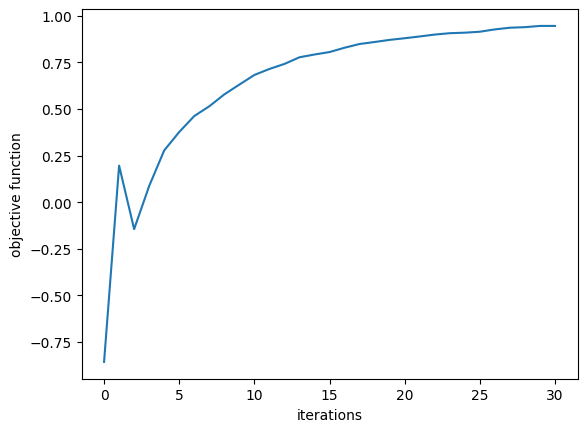

In [22]:
plt.plot(objective_values_history)
plt.xlabel("iterations")
plt.ylabel("objective function")
plt.show()

In [23]:
sim_final = make_sim_with_etch(*params_final)
sim_data_final = web.run(sim_final, task_name="coupler final")

18:18:37 EDT Created task 'coupler final' with task_id                          
             'fdve-6b931dd6-b202-45b1-9c23-76cab4050368' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=161013;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b931dd6-b202-45b1-9c23-76cab4050368\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=953814;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b931dd6-b202-45b1-9c23-76cab4050368\taskId]8;;\]8;id=161013;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b931dd6-b202-45b1-9c23-76cab4050368\=]8;;\]8;id=74745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b931dd6-b202-45b1-9c23-76cab4050368\fdve]8;;\]8;id=161013;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b931dd6-b202-45b1-9c23-76cab4050368\-6b931dd6-b20]8;;\
             ]8;id=161013;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b931dd6-b202-45b1-9c23-76cab4050368\2-45b1-9c23-76cab4050368']8;;\.

Output()

18:18:42 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

18:18:51 EDT status = preprocess

18:18:55 EDT Maximum FlexCredit cost: 0.477. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

18:19:47 EDT early shutoff detected at 16%, exiting.

             status = postprocess

Output()

18:19:50 EDT status = success

             View simulation result at                                          
             ]8;id=978495;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b931dd6-b202-45b1-9c23-76cab4050368\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=492438;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b931dd6-b202-45b1-9c23-76cab4050368\taskId]8;;\]8;id=978495;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b931dd6-b202-45b1-9c23-76cab4050368\=]8;;\]8;id=503804;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b931dd6-b202-45b1-9c23-76cab4050368\fdve]8;;\]8;id=978495;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b931dd6-b202-45b1-9c23-76cab4050368\-6b931dd6-b20]8;;\
             ]8;id=978495;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6b931dd6-b202-45b1-9c23-76cab4050368\2-45b1-9c23-76cab4050368']8;;\.

Output()

18:19:52 EDT loading simulation from simulation_data.hdf5

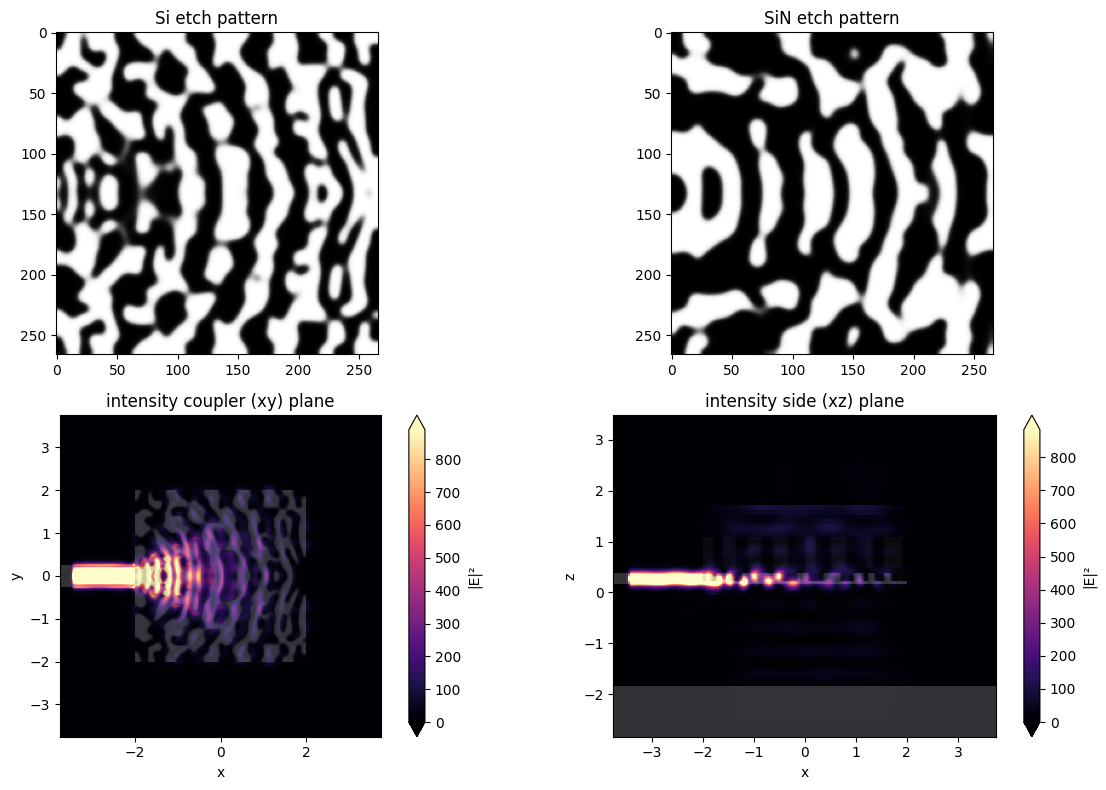

In [24]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), tight_layout=False)

params_Si, params_SiN = params_final
density_Si = get_density_Si(params_Si)
density_SiN = get_density_SiN(params_SiN)

ax1.imshow(np.flipud(1 - density_Si.squeeze().T), cmap="grey")
ax2.imshow(np.flipud(1 - density_SiN.squeeze().T), cmap="grey")
ax1.set_title('Si etch pattern')
ax2.set_title('SiN etch pattern')

sim_data_final.plot_field('field_xy', field_name='E', val='abs^2', ax=ax3)
sim_data_final.plot_field('field_xz', field_name='E', val='abs^2', ax=ax4)
ax3.set_title('intensity coupler (xy) plane')
ax4.set_title('intensity side (xz) plane')

plt.show()

In [28]:
efficiency_final = coupling_efficiency(sim_data_final)
print(f'final coupling efficiency = {100 * efficiency_final:.3f}%')

penalty_val_Si = penalty_Si(params_Si)
penalty_val_SiN = penalty_SiN(params_SiN)
print(f'final penalty (Si) = {penalty_val_Si:.3f}')
print(f'final penalty (SiN) = {penalty_val_SiN:.3f}')

final coupling efficiency = 52.763%
final penalty (Si) = 0.156
final penalty (SiN) = 0.065


In [27]:
# optionally save the coupler history if we want to load it later.
# import pickle
# with open("coupler.pkl", "wb") as file:
#    pickle.dump(params_history, file)